In [1]:
!pip install GEOparse -q

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import GEOparse

In [3]:
PROJECT_ROOT = "/content/mdd-gene-expression-gse98793"

data_raw_dir = f"{PROJECT_ROOT}/data/raw"
data_processed_dir = f"{PROJECT_ROOT}/data/processed"

os.makedirs(data_raw_dir, exist_ok=True)
os.makedirs(data_processed_dir, exist_ok=True)

PROJECT_ROOT, data_raw_dir, data_processed_dir

('/content/mdd-gene-expression-gse98793',
 '/content/mdd-gene-expression-gse98793/data/raw',
 '/content/mdd-gene-expression-gse98793/data/processed')

In [4]:
gse = GEOparse.get_GEO(
    geo="GSE98793",
    destdir=data_raw_dir,
    how="quick"
)

20-Nov-2025 22:35:14 DEBUG utils - Directory /content/mdd-gene-expression-gse98793/data/raw already exists. Skipping.
DEBUG:GEOparse:Directory /content/mdd-gene-expression-gse98793/data/raw already exists. Skipping.
20-Nov-2025 22:35:14 INFO GEOparse - Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE98793&form=text&view=quick to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
INFO:GEOparse:Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE98793&form=text&view=quick to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
20-Nov-2025 22:35:15 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
20-Nov-2025 22:35:15 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
526kB [00:12, 43.1kB/s]
20-Nov-2025 22:35:28 DEBUG downloader - Moving /tmp/tmpw8ee738d to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
DEBUG:GEOparse:Moving /tmp/tmpw8ee738d to /content/mdd-gene-expression-gse98793/data/raw/GSE9879

In [5]:
expr = gse.pivot_samples("VALUE")
expr.shape

(20, 192)

In [6]:
pheno = gse.phenotype_data
pheno.head()
pheno.columns

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.subject group',
       'characteristics_ch1.1.anxiety', 'characteristics_ch1.2.gender',
       'characteristics_ch1.3.age', 'characteristics_ch1.4.tissue',
       'characteristics_ch1.5.batch', 'molecule_ch1', 'extract_protocol_ch1',
       'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol',
       'description', 'data_processing', 'platform_id', 'contact_name',
       'contact_email', 'contact_laboratory', 'contact_department',
       'contact_institute', 'contact_address', 'contact_city',
       'contact_zip/postal_code', 'contact_country', 'supplementary_file',
       'series_id', 'data_row_count'],
      dtype='object')

In [7]:
pheno.head()
pheno.columns

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.subject group',
       'characteristics_ch1.1.anxiety', 'characteristics_ch1.2.gender',
       'characteristics_ch1.3.age', 'characteristics_ch1.4.tissue',
       'characteristics_ch1.5.batch', 'molecule_ch1', 'extract_protocol_ch1',
       'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol',
       'description', 'data_processing', 'platform_id', 'contact_name',
       'contact_email', 'contact_laboratory', 'contact_department',
       'contact_institute', 'contact_address', 'contact_city',
       'contact_zip/postal_code', 'contact_country', 'supplementary_file',
       'series_id', 'data_row_count'],
      dtype='object')

In [8]:
meta = pheno.copy()

# Look at the raw text first
meta["subject_group_raw"] = meta["characteristics_ch1.0.subject group"].astype(str)
meta["subject_group_raw"].value_counts()

,count
subject_group_raw,
CASE; major depressive disorder (MDD) patient,128
CNTL; healthy control,64


In [9]:
# Clean subject group labels
meta["subject_group"] = meta["subject_group_raw"].str.replace("CASE; ", "", regex=False)\
                                                   .str.replace("CNTL; ", "", regex=False)\
                                                   .str.strip().str.lower()

meta["subject_group"].value_counts()

,count
subject_group,
major depressive disorder (mdd) patient,128
healthy control,64


In [10]:
meta["label"] = meta["subject_group"].apply(
    lambda x: 1 if "depressive" in x or "mdd" in x else 0
)

meta["label"].value_counts()

,count
label,
1,128
0,64


In [11]:
# Ensure sample IDs align
common_samples = expr.columns.intersection(meta.index)

expr = expr[common_samples]
meta = meta.loc[common_samples]

expr.shape, meta.shape

((20, 192), (192, 40))

In [12]:
probe_var = expr.var(axis=1)
top_probes = probe_var.sort_values(ascending=False).head(10000).index

expr_filtered = expr.loc[top_probes]
expr_filtered.shape

(20, 192)

In [13]:
expr_filtered_path = os.path.join(data_processed_dir, "GSE98793_expr_top10k.csv")
meta_path = os.path.join(data_processed_dir, "GSE98793_metadata_clean.csv")

expr_filtered.to_csv(expr_filtered_path)
meta.to_csv(meta_path)

expr_filtered_path, meta_path

('/content/mdd-gene-expression-gse98793/data/processed/GSE98793_expr_top10k.csv',
 '/content/mdd-gene-expression-gse98793/data/processed/GSE98793_metadata_clean.csv')

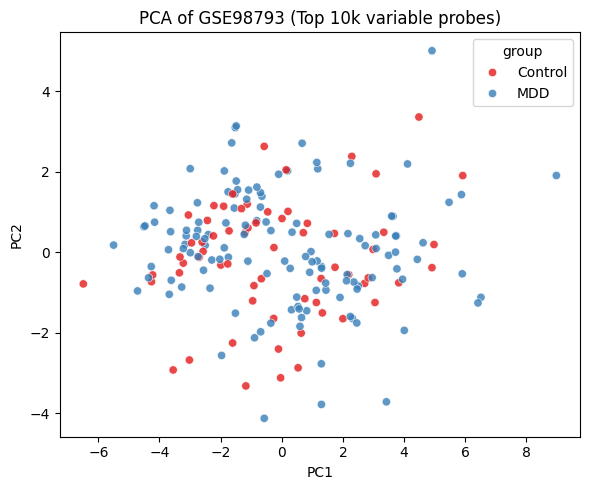

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# samples × genes
X = expr_filtered.T
y = meta["label"].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": y,
    "group": np.where(y == 1, "MDD", "Control")
})

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="group",
    palette="Set1",
    alpha=0.8
)
plt.title("PCA of GSE98793 (Top 10k variable probes)")
plt.tight_layout()
plt.show()